In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow.ci_utils import ci_niter

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

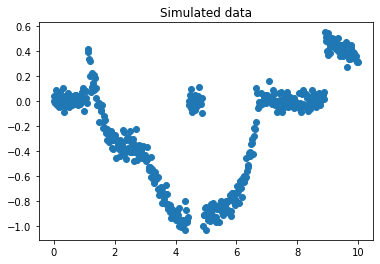

In [3]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

In [4]:
num_iterations = 8000
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)
#kf.lengthscales = 2.
#kf.variance = 1.

kg = gpf.kernels.RBF(variance=5, lengthscales=2)
#kg.lengthscales = 2.
#kg.variance = 5.

# initialise equally spaced inducing point locations
Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)
Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)

In [5]:
# model definition
m = OnOffSVGP(Xtrain, Ytrain
              ,kernf=kf,kerng=kg
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,Zg = Zg
             )

# fix the model noise term
m.likelihood.variance.assign(0.01)
from gpflow import set_trainable
set_trainable(m.likelihood.variance, True)

minibatch_size = 100

N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)

train_iter = iter(train_dataset)#batch(minibatch_size))


In [15]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [23]:
logf = run_adam(m, num_iterations)

In [24]:
logf[-1]

488.13522

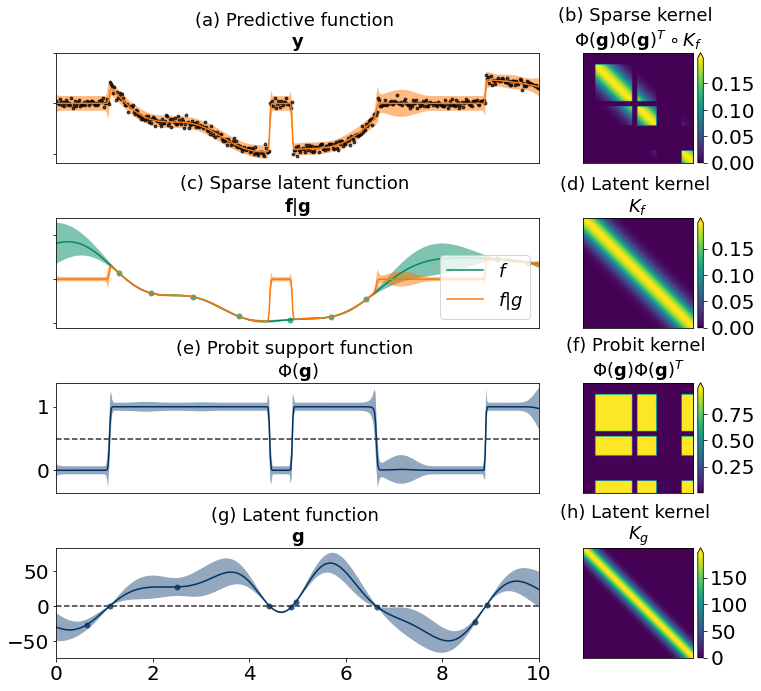

In [25]:
# model plot
PlotOnOff1D(m)

In [14]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    m.training_loss_closure(compile=True),
    m.trainable_variables,
    options={'maxiter':(80000), 'ftol':1e-64, 'gtol':1e-64, 'factr':-1e-64},
)

      fun: -363.86798095703125
 hess_inv: <59x59 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.14407349e-02, -1.63393021e-01, -2.72766590e-01,  3.28763962e-01,
       -1.03197098e-02,  2.09569931e-02, -2.72439003e-01,  2.64869928e-02,
       -3.10678482e-02, -3.73229980e-02, -4.79348183e-01,  1.69180483e-02,
        1.67981033e+01, -5.17402649e+00,  9.59503174e-01, -5.59479833e-01,
        1.13619268e-02,  1.06582314e-01, -3.49750519e-02, -3.60565186e-01,
       -1.33841133e+00,  8.01862717e-01,  2.74032593e-01, -2.02827454e-02,
        5.69966316e-01,  4.20303345e-02,  2.56597519e-01, -5.55753708e-04,
       -3.83913517e-04, -2.86638737e-04, -7.41660595e-04, -8.80360603e-04,
       -7.18295574e-04, -1.13540888e-03, -6.99877739e-04, -8.85367393e-04,
        4.44167852e-03,  1.50355697e-02, -7.87815452e-03,  4.20195460e-01,
        1.47336483e-01, -1.02710724e-02, -3.38847116e-02, -1.06021762e-04,
        1.04190633e-02, -7.20977783e-04, -1.38592720e-03, -5.91665506e-04,


In [14]:
m.training_loss()
loss()

NameError: name 'loss' is not defined

In [20]:
loss = m.training_loss_closure(compile=True)
with tf.GradientTape(persistent=True) as tape:
    loss_val = loss()
grads = tape.gradient(loss_val, m.trainable_variables)

(<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
 array([[ 0.3919201 ],
        [ 0.01459503],
        [ 0.22980738],
        [-0.10441017],
        [ 0.03242266],
        [-0.66403675],
        [ 0.0649147 ],
        [-0.09447801],
        [-0.3127377 ]], dtype=float32)>,
 <tf.Tensor: shape=(9, 1), dtype=float32, numpy=
 array([[-0.02347851],
        [-0.47475052],
        [-0.06516597],
        [11.996902  ],
        [-0.28652954],
        [ 2.679016  ],
        [-0.08364892],
        [-0.09631345],
        [ 0.42164275]], dtype=float32)>,
 <tf.Tensor: shape=(9, 1), dtype=float32, numpy=
 array([[ 0.44412994],
        [-0.07097626],
        [ 0.9400253 ],
        [-0.41461754],
        [-0.6477618 ],
        [ 1.4774704 ],
        [-0.16656685],
        [ 0.44103622],
        [ 0.8212004 ]], dtype=float32)>,
 <tf.Tensor: shape=(9, 1), dtype=float32, numpy=
 array([[ 2.8711557e-04],
        [-5.6010485e-04],
        [-6.2727928e-04],
        [-3.2675266e-04],
        [-2.7894974e-04],

In [22]:
m.u_fm

<Parameter: name=identity, dtype=float32, shape=[9, 1], fn="identity", numpy=
array([[ 0.19046749],
       [-0.27503395],
       [-0.40267178],
       [-0.85481495],
       [-0.8969503 ],
       [-0.7717756 ],
       [-0.10153858],
       [-0.01864392],
       [ 0.4036181 ]], dtype=float32)>

In [23]:
m.u_fs_sqrt

<Parameter: name=softplus, dtype=float32, shape=[9, 1], fn="softplus", numpy=
array([[0.02105285],
       [0.01399992],
       [0.01342663],
       [0.01341257],
       [0.01605919],
       [0.01354569],
       [0.02171946],
       [0.01580126],
       [0.01256675]], dtype=float32)>

In [24]:
m.build_predict(m.X)

(<tf.Tensor: shape=(450, 1), dtype=float32, numpy=
 array([[ 6.08780095e-03],
        [ 4.78832750e-03],
        [ 3.71520151e-03],
        [ 2.85057863e-03],
        [ 2.17208918e-03],
        [ 1.65461993e-03],
        [ 1.27186952e-03],
        [ 9.98084433e-04],
        [ 8.09189107e-04],
        [ 6.84087921e-04],
        [ 6.04819448e-04],
        [ 5.57345862e-04],
        [ 5.30689780e-04],
        [ 5.17106964e-04],
        [ 5.11270366e-04],
        [ 5.09739271e-04],
        [ 5.10322512e-04],
        [ 5.11769264e-04],
        [ 5.13386505e-04],
        [ 5.14770218e-04],
        [ 5.15785650e-04],
        [ 5.16342639e-04],
        [ 5.16303640e-04],
        [ 5.15717489e-04],
        [ 5.14587678e-04],
        [ 5.12719154e-04],
        [ 5.10286016e-04],
        [ 5.07219287e-04],
        [ 5.03511867e-04],
        [ 4.99158574e-04],
        [ 4.94155858e-04],
        [ 4.88500809e-04],
        [ 4.82193631e-04],
        [ 4.75249282e-04],
        [ 4.67641919e-04],
    

In [29]:
conditionals.conditional(m.X, m.Zg, m.kerng, m.u_gm,
                                               full_cov=False, q_sqrt=m.u_gs_sqrt, )

(<tf.Tensor: shape=(450, 1), dtype=float32, numpy=
 array([[-1.16837101e+01],
        [-1.20424194e+01],
        [-1.23910923e+01],
        [-1.27280064e+01],
        [-1.30514250e+01],
        [-1.33595877e+01],
        [-1.36507473e+01],
        [-1.39231586e+01],
        [-1.41751022e+01],
        [-1.44048805e+01],
        [-1.46108580e+01],
        [-1.47914400e+01],
        [-1.49451141e+01],
        [-1.50704355e+01],
        [-1.51660585e+01],
        [-1.52307463e+01],
        [-1.52633619e+01],
        [-1.52629128e+01],
        [-1.52285156e+01],
        [-1.51594610e+01],
        [-1.50551558e+01],
        [-1.49152021e+01],
        [-1.47393370e+01],
        [-1.45274906e+01],
        [-1.42797422e+01],
        [-1.39963646e+01],
        [-1.36777992e+01],
        [-1.33246679e+01],
        [-1.29377670e+01],
        [-1.25180559e+01],
        [-1.20666761e+01],
        [-1.15849152e+01],
        [-1.10742254e+01],
        [-1.05362053e+01],
        [-9.97258663e+00],
    

In [27]:
from gpflow import conditionals

In [87]:
fmean, fvar = conditionals.conditional(m.X, m.Zf, m.kernf, m.u_fm,
                                               full_cov=False, q_sqrt=m.u_fs_sqrt, )
fmean = fmean + m.mean_function(m.X)

gmean, gvar = conditionals.conditional(m.X, m.Zg, m.kerng, m.u_gm,
                                       full_cov=False, q_sqrt=m.u_gs_sqrt, )

# probit transformed expectations for  gamma
ephi_g, ephi2_g, evar_phi_g = m.ProbitExpectations(gmean, gvar)

# compute augmented f
# from above computations we have
# p(f)   = N(f| A*u_fm, Kfnn + A(u_fs - Kfmm)t(A))  A = Kfnm*inv(Kfmm)
# p(f|g) = N(f| diag(ephi_g)* A*u_fm, diag(evar_phi_g)) * (Kfnn + A(u_fs - Kfmm)t(A)))
gfmean = tf.multiply(ephi_g, fmean)
gfvar = tf.multiply(ephi2_g, fvar)
gfmeanu = tf.multiply(evar_phi_g, tf.square(fmean))
        

In [88]:
fvar.shape

TensorShape([450, 1])

In [89]:
def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

In [161]:
num_samples = 100000
g_eps = tf.random.normal(shape=gfmean.shape+(num_samples,))
f_eps = tf.random.normal(shape=fmean.shape+(num_samples,))
y_eps = tf.random.normal(shape=m.Y.shape+(num_samples,))

In [162]:

g_samples = tf.expand_dims(gmean, -1) + tf.math.multiply(g_eps, tf.expand_dims(tf.math.sqrt(gvar),-1))
phi_g_samples = normcdf(g_samples)

In [163]:
# gf = p(f|g)
gf_samples = phi_g_samples*tf.expand_dims(fmean,-1) + \
    phi_g_samples*tf.expand_dims(tf.math.sqrt(fvar),-1)*f_eps

In [164]:
y_samples = gf_samples + y_eps*tf.math.sqrt(m.likelihood.variance)

In [168]:
y_normal = tfp.distributions.Normal(loc=gf_samples, scale=tf.math.sqrt(m.likelihood.variance))
py = y_normal.log_prob(tf.expand_dims(m.Y,-1))

# reduce samples
py_over_samples = tf.reduce_mean(py, -1)
# reduce data
py_over_data = tf.reduce_sum(py_over_samples)
py_over_data

<tf.Tensor: shape=(), dtype=float32, numpy=628.0852>

In [119]:
tfp.distributions.Normal(loc=gf_samples[0,0,0], scale=tf.math.sqrt(m.likelihood.variance)).prob(m.Y[0,0])

<tf.Tensor: shape=(), dtype=float32, numpy=5.054279>

In [116]:
np.min(py_over_samples)

-8.170629

In [101]:
# reduce samples
py_over_samples = tf.reduce_mean(y_samples, -1)
# reduce data
py_over_data = tf.reduce_sum(py_over_samples)

In [102]:
py_over_data

<tf.Tensor: shape=(), dtype=float32, numpy=-105.98813>

In [55]:


# gf = p(f|g)
#gf_samples = tf.expand_dims(gfmean,-1) + tf.math.multiply(eps, tf.expand_dims(tf.math.sqrt(gfvar),-1))

In [56]:
m.variables

(<tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
 array([[1.2988784],
        [1.9645272],
        [2.8405952],
        [3.7769852],
        [4.8369575],
        [5.6917386],
        [6.424134 ],
        [9.137706 ],
        [9.765109 ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
 array([[0.6254422],
        [1.1084019],
        [2.4918509],
        [4.4126277],
        [4.866903 ],
        [4.9634852],
        [6.64851  ],
        [8.668446 ],
        [8.915059 ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
 array([[ 0.13605356],
        [-0.31827718],
        [-0.40340337],
        [-0.8432759 ],
        [-0.9167243 ],
        [-0.8512099 ],
        [-0.45853344],
        [ 0.4537639 ],
        [ 0.37683794]], dtype=float32)>,
 <tf.Variable 'softplus:0' shape=(9, 1) dtype=float32, numpy=
 array([[-4.251199 ],
        [-4.5154996],
        [-4.5701942],
        [-4.5749636],
        [-4.274516 ],
   

In [57]:
gf_samples.shape

TensorShape([450, 1, 10])

In [58]:
py = -0.5 * np.log(2 * np.pi) - 0.5 * tf.math.log(m.likelihood.variance) \
     -0.5 * tf.square(tf.expand_dims(m.Y,-1) - gf_samples)  / m.likelihood.variance \
     - 1/(2*m.likelihood.variance) * tf.expand_dims(gfvar,-1) \
     - 1/(2*m.likelihood.variance) * tf.expand_dims(gfmeanu,-1) \


# reduce samples
py_over_samples = tf.reduce_mean(py, -1)
# reduce data
py_over_data = tf.reduce_sum(py_over_samples)

In [59]:
py_over_data

<tf.Tensor: shape=(), dtype=float32, numpy=554.77747>

In [120]:
tf.reduce_sum(var_exp)

<tf.Tensor: shape=(), dtype=float32, numpy=589.29083>

In [166]:
gfmean, gfvar, gfmeanu, _, _, _, _, _, _ = m.build_predict(m.X)

# compute likelihood
# this should be added to GPFlow likelihood script
var_exp = m.likelihood.variational_expectations(gfmean, gfvar, gfmeanu, m.Y)

In [167]:
tf.reduce_sum(var_exp)

<tf.Tensor: shape=(), dtype=float32, numpy=589.29083>

In [33]:
# Our transform has 3 stages that we chain together via composition:
precision_to_unconstrained = tfb.Chain([
    # step 3: flatten the lower triangular portion of the matrix
    tfb.Invert(tfb.FillTriangular()),
    # step 2: take the log of the diagonals    
    tfb.TransformDiagonal(tfb.Invert(tfb.Exp())),
    # step 1: decompose the precision matrix into its Cholesky factors
    tfb.Invert(tfb.CholeskyOuterProduct()),
])

In [34]:
# sanity checks
m = tf.constant([[1., 2.], [2., 8.]])
m_fwd = precision_to_unconstrained.forward(m)
m_inv = precision_to_unconstrained.inverse(m_fwd)

# bijectors handle tensors of values, too!
m2 = tf.stack([m, tf.eye(2)])
m2_fwd = precision_to_unconstrained.forward(m2)
m2_inv = precision_to_unconstrained.inverse(m2_fwd)

print('single input:')
print('m:\n', m.numpy())
print('precision_to_unconstrained(m):\n', m_fwd.numpy())
print('inverse(precision_to_unconstrained(m)):\n', m_inv.numpy())
print()

print('tensor of inputs:')
print('m2:\n', m2.numpy())
print('precision_to_unconstrained(m2):\n', m2_fwd.numpy())
print('inverse(precision_to_unconstrained(m2)):\n', m2_inv.numpy())

single input:
m:
 [[1. 2.]
 [2. 8.]]
precision_to_unconstrained(m):
 [0.6931472 2.        0.       ]
inverse(precision_to_unconstrained(m)):
 [[1. 2.]
 [2. 8.]]

tensor of inputs:
m2:
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]
precision_to_unconstrained(m2):
 [[0.6931472 2.        0.       ]
 [0.        0.        0.       ]]
inverse(precision_to_unconstrained(m2)):
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]


In [36]:
m

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 2.],
       [2., 8.]], dtype=float32)>

In [50]:
m.likelihood.variance.numpy()

array(0.00510551, dtype=float32)

In [52]:
m.Y

array([[ 4.09904122e-02],
       [ 2.77604163e-03],
       [-1.76562667e-02],
       [ 8.46574679e-02],
       [ 3.55525203e-02],
       [-3.16381976e-02],
       [ 1.96363200e-02],
       [-4.38980795e-02],
       [ 7.44727161e-03],
       [ 7.65939057e-02],
       [ 2.65923887e-02],
       [-3.79833542e-02],
       [ 1.73992068e-02],
       [-3.48901339e-02],
       [ 1.00965738e-01],
       [-8.96849781e-02],
       [-3.29753794e-02],
       [ 3.85726653e-02],
       [-4.10170555e-02],
       [ 8.94409081e-04],
       [ 3.27267610e-02],
       [ 6.28849417e-02],
       [-4.63539995e-02],
       [-8.49388354e-03],
       [-2.35836245e-02],
       [-5.71167469e-03],
       [ 1.84743442e-02],
       [-3.09307631e-02],
       [ 4.00057547e-02],
       [ 2.13348027e-02],
       [-2.36165375e-02],
       [ 1.37975886e-02],
       [ 4.92113568e-02],
       [ 4.96553704e-02],
       [ 3.34104560e-02],
       [-3.24992114e-03],
       [-3.10049318e-02],
       [ 1.12052131e-02],
       [-2.3

In [245]:
gfvar.shape

TensorShape([450, 1])

In [ ]:
norm = tfp.distributions.Normal(loc=gf_samples,scale=m.likelihood.variance.numpy())
py = norm.log_prob(tf.expand_dims(m.Y,-1)) 
# reduce samples
py_over_samples = tf.reduce_mean(py, -1)
# reduce data
py_over_data = tf.reduce_sum(py_over_samples)